# **Modern Robotics — 本編（強化版）**
**理論から実装、そして統合へ**  
*Consolidated & curated from [Modern Robotics](https://hades.mech.northwestern.edu/index.php/Modern_Robotics) / [Coursera](https://www.coursera.org/specializations/modernrobotics)*

- 作成日：2025-09-25
- 形式：Jupyter Notebook（スライド対応；`View > Cell Toolbar > Slideshow`）
- 使い方：上部メニューの **Cell > Run All** で一括実行できます（グラフはmatplotlibで描画）

> 本ノートブックは *Modern_Robotics_Ultimate_Presentation_JP* をベースに、**本編の解説を拡張**した強化版です。


## 📚 Modern Roboticsについて（要旨）
- **現代スクリュー理論**と**積指数（Product of Exponentials; PoE）**で、剛体運動・速度・力を**一貫表現**  
- **Lie群/代数**（SO(3), SE(3), so(3), se(3)）に基づく**グローバルで安定**な運動学・動力学処理  
- **実装フレンドリー**：ホーム姿勢 $M$ と各関節のスクリュー軸 $\mathcal{S}_i$ が分かれば順運動学は1行


## アジェンダ（本編）
1. なぜ **Modern Robotics** か — PoEとスクリュー理論の価値  
2. 配置空間と自由度（Grüblerの公式）  
3. 剛体運動と $\mathrm{SE}(3)$・ツイスト  
4. 順運動学（PoE）ミニデモ  
5. ヤコビアンと操作性（2R）  
6. 逆運動学（数値法）  
7. ダイナミクスの見取り図と **Feedforward + PI**  
8. 軌道生成：パス＋時間スケーリング（3次 vs 5次）  
9. 動作計画（C空間）  
10. マニピュレーション：摩擦円錐とレンチ幾何  
11. 車輪移動：差動駆動の可到達速度集合  
12. Capstone統合（youBot）— 実装ロードマップ


# 1. なぜ Modern Robotics か（PoE アプローチ）
**Product of Exponentials (PoE)** により、各関節のスクリュー軸 $\mathcal{S}_i$ と角度 $\theta_i$ を用いて
\[
T(\boldsymbol\theta)= e^{[\mathcal{S}_1]\theta_1}\, e^{[\mathcal{S}_2]\theta_2}\cdots e^{[\mathcal{S}_n]\theta_n}\, M
\]
と**一行で順運動学**を表現できます。D-H表に比べ、**特異性の扱い・速度/力の統一・フレームの選択自由度**に優れ、実装がシンプルです。

### 🔎 追加解説：**Twist（ツイスト）**とは？
- **定義**：剛体の**瞬間運動**を表す6次元ベクトル $\mathbf{V} = (\boldsymbol\omega,\mathbf{v}) \in \mathbb{R}^6$  
  - $\boldsymbol\omega$：角速度（回転軸と角速度の大きさ）  
  - $\mathbf{v}$：並進の速度成分（スクリュー軸に依存）  
- **幾何学的意味**：任意の剛体運動は「**スクリュー運動**」＝ある軸まわりの回転＋同軸方向の並進に分解可能（ネジの動き）。  
- **座標系**：**空間ツイスト**（基準座標系S表現）と**ボディツイスト**（手先座標系B表現）を使い分け。両者は**随伴（Adjoint）変換**で相互変換。

### 🔧 追加解説：**Skew（歪対称）演算子**・ハット/ブイ
- 3次元ベクトル $\mathbf{a}\in\mathbb{R}^3$ に対し、
  \[ [\mathbf{a}]_\times=\begin{bmatrix}0&-a_z&a_y\\ a_z&0&-a_x\\-a_y&a_x&0\end{bmatrix},\quad [\mathbf{a}]_\times \mathbf{b}=\mathbf{a}\times\mathbf{b} \]
- **hat（ハット）**：$\widehat{\boldsymbol\omega}=[\boldsymbol\omega]_\times$、$\widehat{\mathcal{S}}=\begin{bmatrix}[\boldsymbol\omega]_\times&\mathbf{v}\\ \mathbf{0}^\top&0\end{bmatrix}\in\mathfrak{se}(3)$  
- **vee（ブイ）**：行列 $\widehat{\mathcal{S}}$ をベクトル $\mathcal{S}$ に戻す写像（$\vee$）。  
- **指数写像**：$R=\exp([\hat\omega]\theta)$、$T=\exp([\widehat{\mathcal{S}}]\theta)$。

### 🆚 **PoE vs D-H表**（比較まとめ）
| 観点 | **PoE（積指数）** | **D-Hパラメータ** |
|---|---|---|
| 記述の基本 | スクリュー軸 $\mathcal{S}$ と $M$ | 各リンクに座標系を割当て、4パラメータで隣接変換 |
| 幾何直感 | 軸・ねじ運動で直感的 | 座標系配置の作法依存・直感が薄れやすい |
| 特異性の扱い | Lie群上の指数写像で**安定** | 座標系配置次第で**煩雑**になりやすい |
| 速度/力 | ツイスト＆レンチで**統一**、$J$の転置で静力学 | 速度・力の扱いは**別建て**になりがち |
| 実装 | $T=\prod \exp([\mathcal{S}_i]\theta_i)\,M$ と**一行** | シンボリック変換の**手間**が大きい |
| 適用範囲 | 任意構造・並進関節も自然 | 標準的マニピュレータで有効 |
> 実務目安：**解析/実装/拡張性重視ならPoE**、規格化された教科書流手順の素早い手計算にはD-Hも有用。


# 2. 配置空間と自由度（Grüblerの公式）
- **配置空間（Configuration Space; C-space）**：ロボットの**最小**パラメータ集合。次元が**自由度（DoF）**。  
- **Grüblerの公式**（平面 $m{=}3$、空間 $m{=}6$）：
\[
\mathrm{DoF}= m\,(N-1-J) + \sum_{i=1}^{J} f_i
\]
- 例：**2R平面アーム**のC空間は $S^1\times S^1$（トーラス）。**関節空間の直線**は**作業空間では曲線**に写る。

> 実務Tip：C空間のトポロジ（周期・拘束）を意識すると、逆運動学やプランニングの**分岐**・**多解**・**連結性**の理解が進みます。


/root/miniconda3/envs/modern_robotics/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/modern_robotics/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12508 (\N{KATAKANA LETTER BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/modern_robotics/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/modern_robotics/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/modern_robotics/lib/python3.10/site-packages/IPython/core/pylabtools.py:

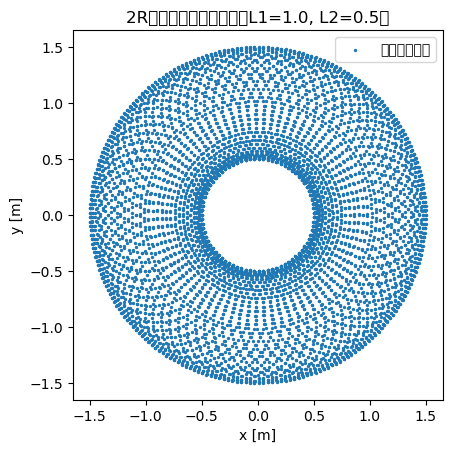

In [1]:
# 2R平面アームの作業空間（散布図）
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 1.0, 0.5
n = 80
t1 = np.linspace(-np.pi, np.pi, n)
t2 = np.linspace(-np.pi, np.pi, n)
X, Y = [], []
for a in t1:
    for b in t2:
        x = L1*np.cos(a) + L2*np.cos(a+b)
        y = L1*np.sin(a) + L2*np.sin(a+b)
        X.append(x); Y.append(y)

plt.figure()
plt.scatter(X, Y, s=2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("2Rロボットの作業空間（L1=1.0, L2=0.5）")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend(["到達可能点群"])
plt.show()

# 3. 剛体運動とツイスト（$\mathrm{SE}(3)$）
- 同次変換 $T=\begin{bmatrix}R&p\\0&1\end{bmatrix}\in \mathrm{SE}(3)$、$R\in \mathrm{SO}(3)$、$p\in\mathbb{R}^3$  
- ツイスト $\mathcal{S}=(\boldsymbol\omega,\mathbf{v})$ の**ハット**：
\[
\widehat{\mathcal{S}}=\begin{bmatrix}[\boldsymbol\omega]_\times & \mathbf{v}\\ \mathbf{0}^\top & 0\end{bmatrix}\in \mathfrak{se}(3)
\]
- 指数写像：$T(\theta)=\exp(\widehat{\mathcal{S}}\,\theta)$ は**ねじ運動**（回転＋並進）。  
- **随伴（Adjoint）**：フレーム変換でツイスト/レンチを一括変換  
  \[
  \mathrm{Ad}_T=\begin{bmatrix}R&0\\ [p]_\times R & R\end{bmatrix},\quad \mathcal{S}_\mathrm{space}=\mathrm{Ad}_T\,\mathcal{S}_\mathrm{body}
  \]

> 覚え方：**回転はRodrigues、剛体はG行列**。$R(\theta)=I+\sin\theta[\hat\omega]+(1-\cos\theta)[\hat\omega]^2$、$p(\theta)=G(\theta)\,v$。


In [2]:
# SE(3)指数写像のミニ実装（一定スクリューでの微小運動）
import numpy as np

def skew3(w):
    wx, wy, wz = w
    return np.array([[0, -wz, wy],
                     [wz, 0, -wx],
                     [-wy, wx, 0]], dtype=float)

def rot_exp(omega_hat, theta):
    W = skew3(omega_hat)
    return np.eye(3) + np.sin(theta)*W + (1-np.cos(theta))*(W@W)

def G_matrix(omega_hat, theta):
    W = skew3(omega_hat)
    return (np.eye(3)*theta + (1-np.cos(theta))*W + (theta-np.sin(theta))*(W@W))

def se3_exp(omega, v, theta):
    if np.linalg.norm(omega) < 1e-12:
        R = np.eye(3)
        p = v * theta
    else:
        w_hat = omega / np.linalg.norm(omega)
        R = rot_exp(w_hat, theta)
        p = G_matrix(w_hat, theta) @ v
    T = np.eye(4)
    T[:3,:3] = R
    T[:3, 3] = p
    return T

omega = np.array([0, 0, 1.0])  # z軸回転
v = np.array([0.2, 0.0, 0.0])  # 軸ずれの並進成分
theta = np.deg2rad(45)
T = se3_exp(omega, v, theta)
T

array([[ 0.70710678, -0.70710678,  0.        ,  0.14142136],
       [ 0.70710678,  0.70710678,  0.        ,  0.05857864],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

# 4. 順運動学（PoE）ミニデモ（2R平面）
ホーム姿勢 $M$ と**空間スクリュー列** $\{\mathcal{S}_1,\mathcal{S}_2,\dots\}$ を用い、
\[
T(\theta)=\Big(\prod_i e^{[\mathcal{S}_i]\theta_i}\Big) M
\]
で手先姿勢を得ます。

> 実務Tip：**空間ヤコビアン/ボディヤコビアン**は、PoEの途中積で簡潔に導出できます（ベクトルの**押し出し/引き戻し**のイメージ）。


In [3]:
# 2R平面のPoE順運動学（se3_expを再利用）
import numpy as np

def T_from_planar_rev(L, q):
    # 2R: 2つのz回転。関節1の原点は基底原点、関節2は (L1, 0)
    L1, L2 = L
    M = np.array([[1,0,0, L1+L2],
                  [0,1,0, 0],
                  [0,0,1, 0],
                  [0,0,0, 1]], float)
    w1 = np.array([0,0,1.0]); q1 = np.array([0,0,0.0]); v1 = -np.cross(w1, q1)
    w2 = np.array([0,0,1.0]); q2 = np.array([L1,0,0.0]); v2 = -np.cross(w2, q2)

    def exp_twist(w, v, th):
        return se3_exp(w, v, th)

    T = exp_twist(w1, v1, q[0]) @ exp_twist(w2, v2, q[1]) @ M
    return T

L = (1.0, 0.5)
q = (np.deg2rad(30), np.deg2rad(-20))
T_fk = T_from_planar_rev(L, q)
T_fk

array([[ 0.98480775, -0.17364818,  0.        ,  1.35842928],
       [ 0.17364818,  0.98480775,  0.        ,  0.58682409],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

# 5. ヤコビアンと操作性（2R）
- **定義**：$\mathbf{V} = J(\boldsymbol\theta)\,\dot{\boldsymbol\theta}$（列は**単一関節**のツイスト）  
- **空間/ボディヤコビアン**：表現フレームの違いに応じて使い分け、随伴で相互変換  
- **マニピュラビリティ**：$JJ^\top$ の固有値・固有ベクトルが**速度の得意方向/苦手方向**を与える  
- **静力学の双対**：$\boldsymbol\tau = J^\top \mathbf{F}$（速度と力は**双対**）

> 実務Tip：**条件数**や**最小特異値**で姿勢の良し悪しを素早く評価。特異点近傍では**減衰擬似逆行列**が安定。


In [4]:
# 操作楕円体（単位関節速度球の像）
import numpy as np
import matplotlib.pyplot as plt

def J_2R(L1, L2, t1, t2):
    s1, c1 = np.sin(t1), np.cos(t1)
    s12, c12 = np.sin(t1+t2), np.cos(t1+t2)
    J = np.array([[-L1*s1 - L2*s12,  -L2*s12],
                  [ L1*c1 + L2*c12,   L2*c12]], float)
    return J

def plot_ellipse(A, ax=None, label="", linestyle='-'):
    import numpy as np
    if ax is None:
        fig = plt.figure()
        ax = fig.gca()
    w, V = np.linalg.eig(A)
    t = np.linspace(0, 2*np.pi, 200)
    ell = (V @ (np.vstack([np.cos(t)/np.sqrt(w[0]), np.sin(t)/np.sqrt(w[1])]))).T
    ax.plot(ell[:,0], ell[:,1], label=label, linestyle=linestyle)
    ax.set_aspect('equal', 'box')
    return ax

L1, L2 = 1.0, 0.5
cfgs = [(np.deg2rad(10), np.deg2rad(20)),
        (np.deg2rad(90), np.deg2rad(1)),
        (np.deg2rad(45), np.deg2rad(90))]
linestyles = ['-', '--', '-.']

plt.figure(figsize=(7, 5))
ax = plt.gca()

for i, (t1, t2) in enumerate(cfgs):
    J = J_2R(L1, L2, t1, t2)
    A = np.linalg.inv(J @ J.T)
    plot_ellipse(A, ax=ax, label=f\"姿勢{i+1}: θ1={np.rad2deg(t1):.0f}°, θ2={np.rad2deg(t2):.0f}°\", 
                 linestyle=linestyles[i])

plt.title("2Rの操作楕円体（単位関節速度球の像）")
plt.xlabel("v_x [m/s]"); plt.ylabel("v_y [m/s]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

SyntaxError: unexpected character after line continuation character (3809599772.py, line 36)

# 6. 逆運動学（2R；Newton–Raphson）
目標 $\mathbf{p}_d$ に対し、反復
\[
\boldsymbol\theta_{k+1}=\boldsymbol\theta_k + J(\boldsymbol\theta_k)^\dagger\,(\mathbf{p}_d-\mathbf{p}(\boldsymbol\theta_k))
\]
で収束させる。**停止条件**（誤差・反復回数・角度変化）と**減衰（Levenberg–Marquardt）**が実務の肝。

> 実務Tip：良い初期値、関節制限の投影、冗長系では**ヌル空間**で二次目的（姿勢・障害物回避）を最適化。


In [ ]:
# Newton-Raphson法で2R逆運動学
import numpy as np
import matplotlib.pyplot as plt

def J_2R(L1, L2, t1, t2):
    s1, c1 = np.sin(t1), np.cos(t1)
    s12, c12 = np.sin(t1+t2), np.cos(t1+t2)
    J = np.array([[-L1*s1 - L2*s12,  -L2*s12],
                  [ L1*c1 + L2*c12,   L2*c12]], float)
    return J

def fk_xy(L1, L2, t1, t2):
    x = L1*np.cos(t1) + L2*np.cos(t1+t2)
    y = L1*np.sin(t1) + L2*np.sin(t1+t2)
    return np.array([x,y])

def ik_2r(L1, L2, p_des, th0=(0.0,0.0), iters=50, tol=1e-8, lam=0.0):
    th = np.array(th0, float)
    hist = [fk_xy(L1,L2,*th)]
    for k in range(iters):
        p = fk_xy(L1,L2,*th)
        e = p_des - p
        if np.linalg.norm(e) < tol:
            break
        J = J_2R(L1,L2,*th)
        # 減衰付き擬似逆（LM風）
        th += (J.T @ np.linalg.inv(J @ J.T + lam*np.eye(2))) @ e
        hist.append(fk_xy(L1,L2,*th))
    return th, np.array(hist)

L1, L2 = 1.0, 0.5
p_des = np.array([1.2, 0.1])
sol, traj = ik_2r(L1,L2,p_des, th0=(np.deg2rad(20), np.deg2rad(10)), lam=1e-4)
plt.figure()
plt.plot(traj[:,0], traj[:,1], marker='o', ms=3)
plt.scatter([p_des[0]],[p_des[1]])
plt.gca().set_aspect('equal','box')
plt.title("2R逆運動学の収束軌跡（目標点へ）")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.legend(["反復の足跡","目標点"])
plt.grid(True, alpha=0.3)
plt.show()
print("解（ラジアン）:", sol)

# 7. ダイナミクス概観と **Feedforward + PI**
- 速度制御では**Pのみは定常偏差**が残りやすい → **PI**で除去  
- 参照ツイスト $V_d$ を**フィードフォワード**、残差は**PI**で修正  
- 2次誤差系の減衰設計：
\[
\ddot e + K_p \dot e + K_i e = 0,\qquad \text{臨界減衰目安 } K_i=\frac{K_p^2}{4}
\]
> 実務Tip：**積分飽和**に注意（アンチワインドアップ）。外乱が大きいときは**PI in task space**で頑健。


In [ ]:
# 単純PI型の誤差応答（オイラー近似）
import numpy as np
import matplotlib.pyplot as plt

dt = 0.001
T = 2.0
N = int(T/dt)

def simulate(Kp, Ki):
    e = 1.0   # 初期誤差
    ed = 0.0
    E = [e]
    for k in range(N):
        edd = -Kp*ed - Ki*e
        ed += edd*dt
        e  += ed*dt
        E.append(e)
    return np.linspace(0,T,N+1), np.array(E)

t1, E1 = simulate(4.0, 4.0)   # 臨界減衰近傍
t2, E2 = simulate(4.0, 0.5)   # 過減衰気味
t3, E3 = simulate(4.0, 8.0)   # 低減衰（振動）

plt.figure()
plt.plot(t1, E1, label="臨界減衰")
plt.plot(t2, E2, label="過減衰")
plt.plot(t3, E3, label="低減衰")
plt.title("PI誤差応答：減衰特性の比較")
plt.xlabel("時間 [s]"); plt.ylabel("誤差 e(t)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8. 軌道生成：**パス** + **時間スケーリング**
- **分離設計**：パス（幾何）とクロック $s(t)$  
- **3次 vs 5次**：速度/加速度の滑らかさ（5次は速度・加速度0境界を満たす）  
- 実機では**台形/S字速度**や**ジャーク制限**を併用（ギア/ベルト保護・快適性）


In [ ]:
# 3次・5次 時間スケーリング比較
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 1, 301)

# 3次（cubic）： 3t^2 - 2t^3
s3  = 3*t**2 - 2*t**3
ds3 = np.gradient(s3, t)
dds3= np.gradient(ds3, t)

# 5次（quintic）： 10t^3 - 15t^4 + 6t^5
s5  = 10*t**3 - 15*t**4 + 6*t**5
ds5 = np.gradient(s5, t)
dds5= np.gradient(ds5, t)

plt.figure(); plt.plot(t, s3, label="3次"); plt.plot(t, s5, label="5次")
plt.title("時間スケーリング：進行度 s(t)"); plt.xlabel("正規化時間 t"); plt.ylabel("s(t)"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(t, ds3, label="3次"); plt.plot(t, ds5, label="5次")
plt.title("時間スケーリング：速度 ds/dt"); plt.xlabel("正規化時間 t"); plt.ylabel("ds/dt"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(t, dds3, label="3次"); plt.plot(t, dds5, label="5次")
plt.title("時間スケーリング：加速度 d2s/dt2"); plt.xlabel("正規化時間 t"); plt.ylabel("d2s/dt2"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# 9. 動作計画（C空間）
- ロボットを**点**に、障害物を**C障害物**に写像 → 衝突判定が容易  
- 4系統の代表手法：  
  1) **グリッド**（A*等：決定論・最短経路だが高次元に弱い）  
  2) **サンプリング**（PRM/RRT：高次元に強い・確率的完全性）  
  3) **ポテンシャル**（軽量だが局所極小）  
  4) **最適化**（CHOMP/TrajOpt：滑らかさ・コスト最小）  
- 実務では組合せ：サンプリングで初期解→最適化で**平滑化/マージン付与**。


# 10. マニピュレーション：摩擦円錐とレンチ
- クーロン摩擦：$\|f_t\|\le \mu f_n$ → 半角 $\alpha=\tan^{-1}\mu$ の**摩擦円錐**  
- 接触の**レンチ**（力＋モーメント）を集め、**正スパン**が空間を覆えば**力閉包（Force Closure）**  
- 判定は線形計画/凸包で実装可能（2Dなら視覚的に把握しやすい）。


In [ ]:
# 摩擦円錐（2D簡略）
import numpy as np
import matplotlib.pyplot as plt

mu = 0.5
alpha = np.arctan(mu)
n = np.array([0,1])

dir1 = np.array([ np.sin(alpha), np.cos(alpha)])
dir2 = np.array([-np.sin(alpha), np.cos(alpha)])

t = np.linspace(0, 1.0, 50)
r1 = np.outer(t, dir1)
r2 = np.outer(t, dir2)

plt.figure()
plt.plot(r1[:,0], r1[:,1], label="稜線1")
plt.plot(r2[:,0], r2[:,1], label="稜線2")
plt.axvline(0, linestyle="--")
plt.title("摩擦円錐（平面近似；μ=0.5）")
plt.xlabel("接線方向 f_t"); plt.ylabel("法線方向 f_n")
plt.legend()
plt.gca().set_aspect('equal','box')
plt.grid(True, alpha=0.3)
plt.show()

# 11. 車輪移動：差動駆動の可到達速度集合（$v$-$\omega$）
車輪速度制限 $|\dot\theta_L|,|\dot\theta_R|\le \dot\theta_{\max}$ より、
\[
v=\tfrac{r}{2}(\dot\theta_R+\dot\theta_L),\quad 
\omega=\tfrac{r}{2d}(\dot\theta_R-\dot\theta_L)
\]
→ $(v,\omega)$は**ひし形**（正方形の線形写像）。**台形速度制限**や**摩擦限界**を含めると多面体に拡張。

> 実務Tip：可到達速度領域をプロファイル制約として**オンライン**に使うと、**安全で飽和しない**速度制御が実現します。


In [ ]:
# 差動駆動の可到達速度集合（v-ω）
import numpy as np
import matplotlib.pyplot as plt

r = 0.05    # 車輪半径
d = 0.20    # 半トレッド
wmax = 12.0 # [rad/s]

verts_wr = np.array([[-wmax,-wmax], [-wmax, wmax], [wmax, wmax], [wmax,-wmax], [-wmax,-wmax]])
def map_to_vw(wL, wR):
    v = r*0.5*(wR + wL)
    w = r/(2*d)*(wR - wL)
    return np.array([v, w])

poly = np.vstack([map_to_vw(wL, wR) for (wL, wR) in verts_wr])

plt.figure()
plt.plot(poly[:,0], poly[:,1])
plt.title("差動駆動の可到達速度集合（v-ωのひし形領域）")
plt.xlabel("並進速度 v [m/s]"); plt.ylabel("角速度 ω [rad/s]")
plt.grid(True, alpha=0.3)
plt.show()

# 12. Capstone統合（youBot）— 実装ロードマップ
- **Milestone 1**：メカナム運動学 + $SE(3)$指数で姿勢更新  
- **Milestone 2**：8セグメント参照軌道（5次スケーリング）  
- **Milestone 3**：フィードフォワード + ヤコビアン擬似逆  
- **Milestone 4**：タスク空間 **PI**（必要なら**積分飽和対策**）

> 重要：**フィードフォワードが主役**、**PIは残差の清掃係**。実装は *NextState* → *Trajectory* → *Control* の順で段階的に。


In [ ]:
# （任意）日本語フォントやModern Roboticsライブラリが無い環境向けのインストール例
# !pip install japanize-matplotlib modern-robotics ipywidgets